# Combine DIC data with X-ray in order to calculate multiaxial flow curve

- Use pylab inline

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


- Dependents

In [2]:
import os, time
from MP.mat import mech
from glob import glob
import RS
reload(RS)
from RS import sfig_class
reload(sfig_class)

from RS import analyze_proto,sff_plot
import matplotlib as mpl
from MP import progress_bar, lib
from MP import mat
mech=mat.mech

mpl_lib=lib.mpl_lib
uet=progress_bar.update_elapsed_time
GS=mpl.gridspec.GridSpec
fc=mat.mech.FlowCurve

- Name of DIC files

In [3]:
date='20141029'
path='/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/BB/'
fn_DIC=os.path.join(path,date,'DIC/DIC_results.txt')
dic_dat=np.loadtxt(fn_DIC,skiprows=1).T

# Read lab note book in order to match Xray file and DIC index

In [4]:
print os.popen('ls -ls %s'%os.path.join(path,date,'Xray')).read()

total 520
8 -rw-------  1 yj  admin  1471 Mar 30 15:32 29OCT14_0002Data.txt
8 -rw-------  1 yj  admin  3011 Mar 30 15:32 29OCT14_0002Data1Phi-135.txt
8 -rw-------  1 yj  admin  3010 Mar 30 15:32 29OCT14_0002Data2Phi-45.txt
8 -rw-------  1 yj  admin  3008 Mar 30 15:32 29OCT14_0002Data3Phi0.txt
8 -rw-------  1 yj  admin  3008 Mar 30 15:32 29OCT14_0002Data4Phi90.txt
8 -rw-------  1 yj  admin  1472 Mar 30 15:32 29OCT14_0003Data.txt
8 -rw-------  1 yj  admin  3009 Mar 30 15:32 29OCT14_0003Data1Phi-135.txt
8 -rw-------  1 yj  admin  3008 Mar 30 15:31 29OCT14_0003Data2Phi-45.txt
8 -rw-------  1 yj  admin  3007 Mar 30 15:31 29OCT14_0003Data3Phi0.txt
8 -rw-------  1 yj  admin  3007 Mar 30 15:31 29OCT14_0003Data4Phi90.txt
8 -rw-------  1 yj  admin  1475 Mar 30 15:31 29OCT14_0004Data.txt
8 -rw-------  1 yj  admin  3011 Mar 30 15:31 29OCT14_0004Data1Phi-135.txt
8 -rw-------  1 yj  admin  3010 Mar 30 15:31 29OCT14_0004Data2Phi-45.txt
8 -rw-------  1 yj  admin  3008 Mar 30 15:33 29OCT14_0004Data3Phi

- Making a fref file for Proto data analysis

In [5]:
# ------------------------------------------------------------------------
# Find suitable experimental stress factor file
#fn_sff='/Users/yj/GoogleDrive/expdat/Marciniak-X-ray-IF/YJ_BB_10times.sff'
fn_sff='/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/YJ_BB_10times.sff'


# ------------------------------------------------------------------------
# Refer to Laboratory notebook to match up the X-ray data filename 
# and DIC image number
DIC_XRD="""#7 29OCT14_0003.tr
#8    29OCT14_0003.tr
#203  29OCT14_0004.tr
#204  29OCT14_0004.tr
#205  29OCT14_0005.tr
#206  29OCT14_0005.tr
#206  29OCT14_0005.tr
#207  29OCT14_0006.tr
#208  29OCT14_0006.tr
#209  29OCT14_0007.tr
#210  29OCT14_0007.tr
#211  29OCT14_0008.tr
#212  29OCT14_0008.tr
#213  29OCT14_0009.tr
#214  29OCT14_0009.tr
#215  29OCT14_0010.tr
#216  29OCT14_0010.tr
#217  29OCT14_0011.tr
#218  29OCT14_0011.tr
#219  29OCT14_0012.tr
#220  29OCT14_0012.tr
#221  29OCT14_0013.tr
#222  29OCT14_0013.tr
#223  29OCT14_0014.tr"""

# ------------------------------------------------------------------------

fn_fref=fn_DIC.split('DIC')[0]+'f_fref.txt'
f_fref=open(fn_fref,'w')

f_fref.write(fn_sff)
f_fref.write('  MajorStrainColumn: 2\n')
f_fref.write(('%14s'+'%12s '*4+' %5s'+'%12s '*4+' %14s\n')%(
        'filename','Exx','Eyy','Exy','Ezz','DIC','Exx_e','Eyye','SIG_a','SIG_e','Date'))
lines=DIC_XRD.split('\n')
inds = []; fns = []

## flow curve obj
myfc=fc()
Ex,Ey,Exy,Ez=[],[],[],[]

Ex_std =[]
Ey_std =[]
DIC_sigma_avg=[]; DIC_sigma_std=[]

for line in lines:
    ind,fn=line.split()
    ind=int(ind.split('#')[-1])
    fn = fn.split('.tr')[0]
    inds.append(ind); fns.append(fn)
    
    col = dic_dat[0]
    ix=np.where(col==ind)[0]
    i = int(col[ix][0]) ## dic index
    # print ix,i

    exx = dic_dat[5][ix]
    eyy = dic_dat[7][ix]
    exy = dic_dat[9][ix]
    ezz = -exx-eyy    
    # -----------------------------------------
    """ Additional elements..."""
    exx_std       = dic_dat[6][ix]
    eyy_std       = dic_dat[8][ix]
    DIC_sigma_a   = dic_dat[11][ix]
    DIC_sigma_e   = dic_dat[12][ix]
    # -----------------------------------------

    f_fref.write(('%14s '+'%+11.5e '*4+'%5i '+'%+11.5e '*4+' %14s\n')%(
            fn, exx, eyy, exy, ezz,i,exx_std,eyy_std,DIC_sigma_e,DIC_sigma_e,date))
    Ex.append(exx);Ey.append(eyy);Exy.append(exy);Ez.append(ezz)
    Ex_std.append(exx_std)
    Ey_std.append(eyy_std)
    DIC_sigma_avg.append(DIC_sigma_a)
    DIC_sigma_std.append(DIC_sigma_e)

myfc.get_strain(Ex,0,0)
myfc.get_strain(Ey,1,1)
myfc.get_strain(Exy,0,1)
myfc.get_strain(Exy,1,0)
myfc.get_strain(Ez,2,2)
myfc.set_zero_epsilon_ij(2,1)
myfc.set_zero_epsilon_ij(0,2)
myfc.get_vm_strain()
myfc.get_vm_stress()

myfc.DIC_sigma_avg=DIC_sigma_avg
myfc.DIC_sigma_std=DIC_sigma_std
myfc.Ex_std=Ex_std
myfc.Ey_std=Ey_std

f_fref.close()
print '-'*50
print fn_fref, 'has been created:\n Use it for further stress analysis'
print '-'*50

--------------------------------------------------
/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/BB/20141029/f_fref.txt has been created:
 Use it for further stress analysis
--------------------------------------------------


In [6]:
print os.popen('head -n 5 %s'%os.path.join(path,date,'f_fref.txt')).read()

/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/YJ_BB_10times.sff  MajorStrainColumn: 2
      filename         Exx          Eyy          Exy          Ezz    DIC       Exx_e         Eyye        SIG_a        SIG_e            Date
  29OCT14_0003 +3.31829e-05 +1.55940e-04 +2.03186e-04 -1.89123e-04     7 +8.61690e-04 +4.47834e-04 +8.82581e-04 +8.82581e-04        20141029
  29OCT14_0003 +5.55872e-05 +1.95862e-04 +1.93017e-04 -2.51449e-04     8 +8.65209e-04 +4.62892e-04 +8.86442e-04 +8.86442e-04        20141029
  29OCT14_0004 +9.19757e-02 +9.06326e-02 +6.87664e-04 -1.82608e-01   203 +2.49612e-03 +2.06815e-03 +1.06233e-03 +1.06233e-03        20141029



+ Running analyze_proto.main for the X-ray and DIC experiments to calculate
  stress/strain

In [7]:
## plastic strain of the points where the X-ray d-spacing
## were meausured are important information that is utilized over the X ray analysis.
## If, fc or fn_str are not given, the below application
## bases on the strain given in the fref file -
## the two major strain components are used with assumption
## that the sample was in 'equi-biaxial' strain.
t0=time.time()
RS=analyze_proto.main(path=os.path.join(path,date,'Xray'),
                   fn_sf=fn_sff,fref=os.path.join(path,date,'f_fref.txt'),
                   ind_plot=True)
uet(time.time()-t0)

---------------------------------------------
Strain information where SF/IG were measured
requires either fc or fn_str specified
If not the strain column in fn_sf is used,
subsequent analysis is performed by assuming
that the sample is in equibiaxial strain
---------------------------------------------


#-----------------------------------------------------#
 Interpolate SF and IG for matching with D-spacings
epsilon_vm:
[  2.01966763e-04   2.64169844e-04   1.82609946e-01   1.82704813e-01
   3.69646009e-01   3.69767016e-01   3.69767016e-01   5.44497584e-01
   5.44522641e-01   6.01076593e-01   6.01328695e-01   6.63155353e-01
   6.63322126e-01   7.16025809e-01   7.16115266e-01   7.68082803e-01
   7.68175113e-01   7.94891367e-01   7.94885003e-01   8.22347387e-01
   8.22385461e-01   8.36239849e-01   8.36483319e-01   8.32707764e-01]
Strain reference at which sf was measured:
[ 0.    0.02  0.2   0.5   0.7 ]
  ** Phi angles of SF are different **
  ** Phi angles of IG are different **
#----

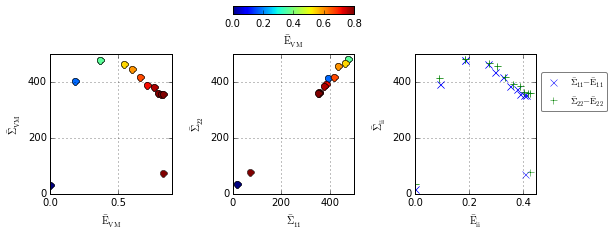

In [8]:
""" 
RS.EXP.flow.epsilon, RS.flow.sigma
"""
mn=0;mx=0.8
norm = mpl.colors.Normalize(vmin=mn,vmax=mx)
cmap, m = mpl_lib.norm_cmap(mn=mn,mx=mx)

fx=9
fy=fx*0.35
fig=plt.figure(figsize=(fx,fy))
gs=GS(20,3,wspace=0.5)
ax1=fig.add_subplot(gs[5:,0])
ax2=fig.add_subplot(gs[5:,1])
ax3=fig.add_subplot(gs[5:,2])

nstp = RS.EXP.flow.nstp


for istp in xrange(nstp):
    c=m.to_rgba(RS.EXP.flow.epsilon_vm[istp])
    ax2.plot(RS.flow.sigma[0,0][istp],RS.flow.sigma[1,1][istp],
             'o',mec='k',mfc=c)
    ax1.plot(RS.EXP.flow.epsilon_vm[istp],RS.flow.sigma_vm[istp],'o',c=c)
# ax2.plot(RS.flow.sigma[0,0],RS.flow.sigma[1,1],'k--')

ax3.plot(RS.EXP.flow.epsilon[0,0],RS.flow.sigma[0,0],'x',label=r'$\mathrm{\bar{\Sigma}_{11} - \bar{E}_{11}}$')
ax3.plot(RS.EXP.flow.epsilon[1,1],RS.flow.sigma[1,1],'+',label=r'$\mathrm{\bar{\Sigma}_{22} - \bar{E}_{22}}$')


for ax in fig.axes:
    ax.set_ylim(0.,);ax.set_xlim(0.,)
    ax.locator_params(nbins=4)
    ax.grid()

ax2.set_xlabel(r'$\mathrm{\bar{\Sigma}_{11}}$')
ax2.set_ylabel(r'$\mathrm{\bar{\Sigma}_{22}}$')
ax3.set_xlabel(r'$\mathrm{\bar{E}_{ii}}$')
ax3.set_ylabel(r'$\mathrm{\bar{\Sigma}_{ii}}$')
ax1.set_xlabel(r'$\mathrm{\bar{E}_{VM}}$')
ax1.set_ylabel(r'$\mathrm{\bar{\Sigma}_{VM}}$')
ax3.legend(loc='best',fontsize=9,numpoints=1,bbox_to_anchor=(1,0.9))


axcb=fig.add_subplot(gs[0,1])
cb=mpl.colorbar.ColorbarBase(axcb,cmap=cmap,orientation='horizontal',
                          norm=norm,filled=True,format='%3.1f')
# axcb.locator_params(nbins=4)
axcb.set_xlabel(r'$\mathrm{\bar{E}_{VM}}$')
cb.set_ticks(np.linspace(mn,mx,5))
#mpl_lib.add_cb(ax=axcb,cmap=cmap, filled=True,
#               format='%5.3f',norm=norm,
#               ylab=r'$\mathrm{\bar{E}_{VM}}$')



- Pickle the object 'RS' and save to a file

In [9]:
import cPickle as pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

fn = os.path.join(path,date,'RS.pck')
print fn
save_object(obj=RS, filename=fn)

fn = os.path.join('../../../pickles/RS_%s.pck'%date)
print os.path.join(os.getcwd(),fn)
save_object(obj=RS, filename=fn)


fn = os.path.join('../../../pickles/RS_DIC_%s.pck'%date)
print os.path.join(os.getcwd(),fn)
save_object(obj=myfc, filename=fn)

/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/BB/20141029/RS.pck
/Users/yj/repo/FLD_DIC_XRAY/tutorials/XRD_analysis/IF_steel/BB/../../../pickles/RS_20141029.pck
/Users/yj/repo/FLD_DIC_XRAY/tutorials/XRD_analysis/IF_steel/BB/../../../pickles/RS_DIC_20141029.pck
